<a href="https://colab.research.google.com/github/kristinanett/02456-deep-learning-with-PyTorch/blob/master/4_Convolutional/4.1-CNN-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

Originally created for a previous version of the [02456-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning) course material, but [converted to PyTorch](https://github.com/pytorch/tutorials).
See repos for credits.

# Dependancies and supporting functions
Loading dependancies and supporting functions by running the code block below.

In [59]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Convolutional Neural networks 101

Convolution neural networks are one of the most succesfull types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. 
They are able to extract structural relations in the data such as spatial in images or temporal in time series.

In this lab we'll experiment with inserting 2D-convolution layers in the fully connected neural networks introduced in lab 1 (`1_Feedforward`).
We'll further experiment with stacking of convolution layers, max pooling and strided convolutions which are all important techniques in current convolution neural network architectures.
Lastly we'll try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.

If you haven't watched Jason Yosinski and colleague [awesome video on visualizing convolutional networks](https://www.youtube.com/watch?v=AgkfIQ4IGaM) you definitely should do so now.

If you are unfamilar with the the convolution operation https://github.com/vdumoulin/conv_arithmetic have a nice visualization of different convolution variants.
For a more indepth tutorial please see http://cs231n.github.io/convolutional-networks/ or http://neuralnetworksanddeeplearning.com/chap6.html.

## Reminder: What are convolutional networks?

ConvNets are in may respects very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers
 * Each layer is parameterized by weights and biases
 * Each layer has an element-wise non-linear transformation (activation function)
 * There are no cycles in the connections (more on this in later labs)

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer.
This is not the case for ConvNets.
In ConvNets each unit is only connected to a small subset of the input units.
This is called the *receptive field* of the unit.

#### Let us look at a quick example.
The input (green matrix) is `1x5x5` dimensional tensor - i.e. it has one `channel` (like a grayscale image) and the map is of size `5x5`.
Let us define a `1x3x3` kernel (yellow submatrix).
The kernel weights are indicated by red in the bottom right of each elment.
The computation can be thought of as first an elementwise multiplication, and then summing the results.
Here we use a stride of 1, as shown in this animation:

<img src="https://github.com/kristinanett/02456-deep-learning-with-PyTorch/blob/master/4_Convolutional/images/convolutions.gif?raw=1" style="width: 400px;"/> 
[GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)]

After having convolved the image we perform an elementwise non-linear transformation on the *convolved features*.
In this example the input is a 2D *feature map* with depth 1.


# Assignment 1

### Assignment 1.1: Manual calculations

Perform the following computation, and write the result below.

![](https://github.com/kristinanett/02456-deep-learning-with-PyTorch/blob/master/4_Convolutional/images/conv_exe.png?raw=1)

1. Manually convolve the input, and compute the convolved features. No padding and stride of 1.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

**Answer:**

Convolution result is a 2x2 matrix: [[8, 20];[14, 25]]

The pooling result is the maximum of those 4 elements therefore 25.

### Assignment 1.2: Output dimensionality

Given the following 3D tensor input `(channel, height, width)` , a given amount (`channels_out`) of filters `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`, calculate the output dimensionality if it's valid.

1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)
 * **Answer:** (16, 24, 24)
2. input tensor with dimensionality (2, 32, 32) and 24 filters of size (2, 3, 3) with stride (1, 1) and padding (0, 0)
 * **Answer:** (24, 30, 30)
3. input tensor with dimensionality (10, 32, 32) and 3 filters of size (10, 2, 2) with stride (2, 2) and padding (0, 0)
 * **Answer:** (3, 16, 16)
4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)
 * **Answer:** not valid
5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)
 * **Answer:** (112, 256, 256)
 

# Data: MNIST

The code below downloads and loads the same MNIST dataset as before.
Note however that the data has a different shape this time, namely `(num_samples, num_channels, height, width)`.

In [60]:
## Download the MNIST dataset, if you haven't already

!if [ ! -f mnist.npz ]; then wget -N https://www.dropbox.com/s/qxywaq7nx19z72p/mnist.npz; else echo "mnist.npz already downloaded"; fi

mnist.npz already downloaded


In [61]:
## LOAD the mnist data. 

# To speed up training we'll only work on a subset of the data.
# Note that we reshape the data from 
#  (nsamples, num_features) = (nsamples, nchannels*rows*cols)
#    -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels, rows, cols = 1, 28, 28

x_train = data['X_train'][:1000].astype('float32')
x_train = x_train.reshape((-1, nchannels, rows, cols))
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1, nchannels, rows, cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1, nchannels, rows, cols))
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 1, 28, 28)
targets_train (1000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


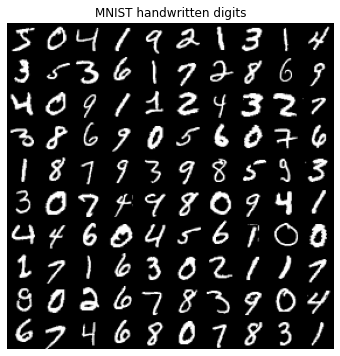

In [62]:
## plot a few MNIST examples

idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

# Define a simple feed forward neural network

In [63]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [64]:
# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 100
padding_conv1 = 2
   
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # out_dim = (input_dim - filter_dim + 2padding) / stride + 1
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.conv_out_height = compute_conv_dim(height)
        self.conv_out_width = compute_conv_dim(width)
        
        # add dropout to network
        # self.dropout = Dropout2d(p=0.5)
        self.l1_in_features = num_filters_conv1 * self.conv_out_height * self.conv_out_width
        #self.l1_in_features = channels * height * width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): #x.size() = [batch, channel, height, width]
        x = relu(self.conv_1(x))
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        x = x.view(-1, self.l1_in_features)
        #x = self.dropout(relu(self.l_1(x)))
        x = relu(self.l_1(x))
        return softmax(self.l_out(x), dim=1)


net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l_1): Linear(in_features=12544, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=10, bias=False)
)


In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [66]:
#Test the forward pass with dummy data
x = np.random.normal(0,1, (5, 1, 28, 28)).astype('float32')
out = net(Variable(torch.from_numpy(x)))
out.size(), out

(torch.Size([5, 10]),
 tensor([[0.1127, 0.1038, 0.1004, 0.1091, 0.0977, 0.1008, 0.0895, 0.0886, 0.1013,
          0.0960],
         [0.1045, 0.0901, 0.0928, 0.1173, 0.1155, 0.1059, 0.0894, 0.0917, 0.0967,
          0.0962],
         [0.1171, 0.0944, 0.1015, 0.1083, 0.1070, 0.1030, 0.0951, 0.0904, 0.0907,
          0.0924],
         [0.1110, 0.1003, 0.0883, 0.1145, 0.1016, 0.0981, 0.1010, 0.0955, 0.1023,
          0.0874],
         [0.1123, 0.0977, 0.1043, 0.1063, 0.1020, 0.1040, 0.0864, 0.0919, 0.0995,
          0.0957]], grad_fn=<SoftmaxBackward>))

Notice how the output's probabilities are nicely distributed.
The built-in nn functions (layers) alreay have a sane initialization of the weights.

Epoch  1 : Train Loss 0.220717 , Train acc 0.525000, Valid acc 0.498000
Epoch 11 : Train Loss 0.151220 , Train acc 0.962000, Valid acc 0.850000
Epoch 21 : Train Loss 0.149029 , Train acc 0.974000, Valid acc 0.862000
Epoch 31 : Train Loss 0.148648 , Train acc 0.975000, Valid acc 0.868000
Epoch 41 : Train Loss 0.148600 , Train acc 0.976000, Valid acc 0.874000

Test set Acc:  0.882000


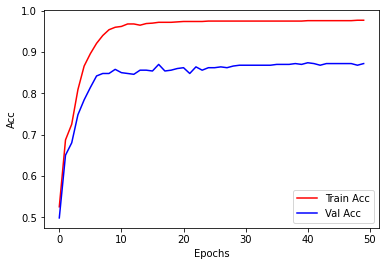

In [67]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

batch_size = 100
num_epochs = 50
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

# Assignment 2

1. Note the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 

Standard feedforward: Train acc 0.978000, Valid acc 0.848000

With convolutional: Train acc 0.977000, Valid acc 0.858000

 
2. Notice that the size of the image reduces. This can cause loss of information in convolutional networks that apply many convolutional layers. To avoid such add adequate padding to the convolutional layer.

With padding: Train acc 0.976000, Valid acc 0.874000
 
3. Can the performance be increases even further by stacking more convolution layers ?
 
4. Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. Try to either: 
 
   - add a maxpool layer (add arguement kernel_size=2, stride=2) after the convolution layer, or
   - set add stride=2 to the arguments of the convolution layer, make it fit with the kernel size
     
  Verify that this decreases spatial dimension of the image (`print(l_conv_x.size())` or `print(l_maxpool_x.size())` in your forward pass). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?

# Visualization of filters
Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

In [68]:
# to start with we print the names of the weights in our network
names_and_vars = {x[0]: x[1] for x in net.named_parameters()}
print(names_and_vars.keys())

dict_keys(['conv_1.weight', 'conv_1.bias', 'l_1.weight', 'l_1.bias', 'l_out.weight'])


(16, 1, 5, 5) i.e. the shape is (channels_out, channels_in, filter_height, filter_width)
learned filter values


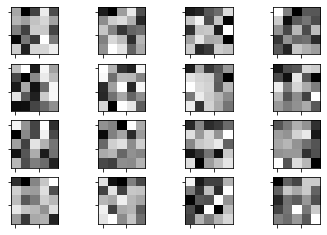

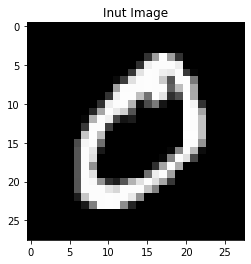

Response from input image convolved with the filters


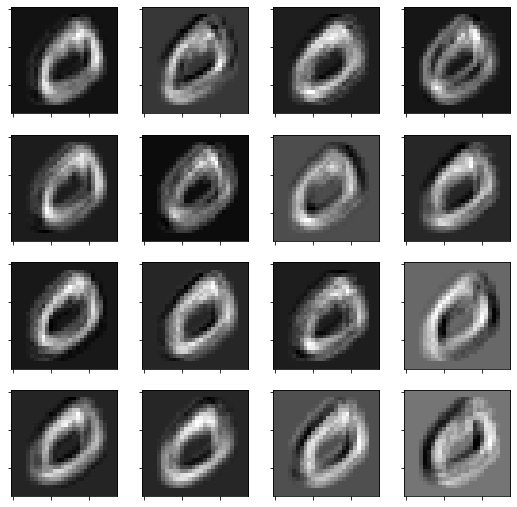

In [69]:
### ERROR - If you get a key error, then you need to define l_conv1 in your model!
if not 'conv_1.weight' in names_and_vars:
    print("You need to go back and define a convolutional layer in the network.")
else:
    np_W = names_and_vars['conv_1.weight'].data.numpy() # get the filter values from the first conv layer
    print(np_W.shape, "i.e. the shape is (channels_out, channels_in, filter_height, filter_width)")
    channels_out, channels_in, filter_size, _ = np_W.shape
    n = int(channels_out**0.5)

    # reshaping the last dimension to be n by n
    np_W_res = np_W.reshape(filter_size, filter_size, channels_in, n, n)
    fig, ax = plt.subplots(n,n)
    print("learned filter values")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())

    idx = 1
    plt.figure()
    plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
    plt.title('Inut Image')
    plt.show()

    #visalize the filters convolved with an input image
    from scipy.signal import convolve2d
    np_W_res = np_W.reshape(filter_size, filter_size, channels_in, n, n)
    fig, ax = plt.subplots(n,n,figsize=(9,9))
    print("Response from input image convolved with the filters")
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same'),
                           cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())

# Assignment 3

The visualized filters will likely look most like noise due to the small amount of training data.

1. Try to use 10000 traning examples instead and visualise the filters again
 
2. Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
   - remember to use `net.train()` and `net.eval()` properly.
 
3. Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 
   - remember to use `net.train()` and `net.eval()` properly.

Again, if you didn't already, you really should [watch this video](https://www.youtube.com/watch?v=AgkfIQ4IGaM).